# Cart-pole swing-up problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify, Matrix)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [4]:
from functools import lru_cache

In [5]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [6]:
# Creating symbols and dynamic symbols

m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [7]:
# Definition of the physics system

N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

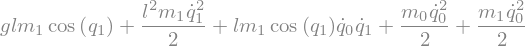

In [8]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [9]:
# Defining the control forces and external actions, and applying them to our system

u0, u1 = dynamicsymbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


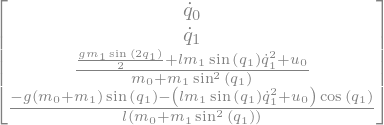

In [10]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

In [11]:
RHS_small.shape

In [12]:
RHS_d = RHS_small.diff(t)
RHS_d = simplify(RHS_d)

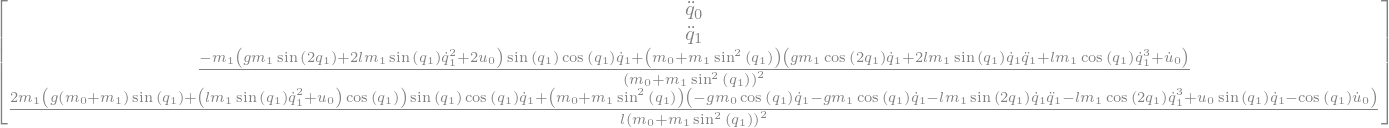

In [13]:
RHS_d

In [14]:
RHS_d_exp = RHS_small.copy()

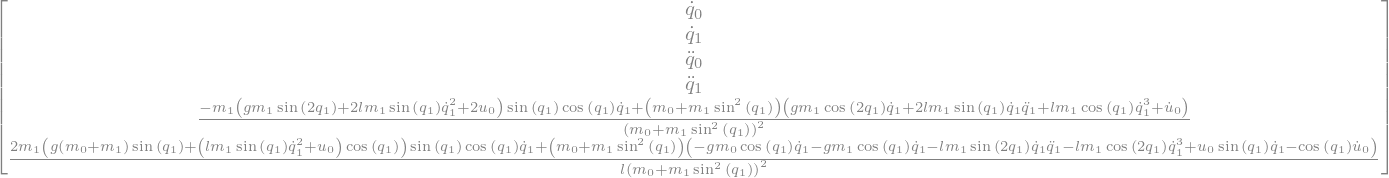

In [15]:
RHS_d_exp = Matrix([RHS_small[i] for i in [0,1]]+[RHS_d[i] for i in range(4)])
RHS_d_exp

In [16]:
q2 = dynamicsymbols('q_2')
q2d = q2.diff()
q2dd = q2d.diff()

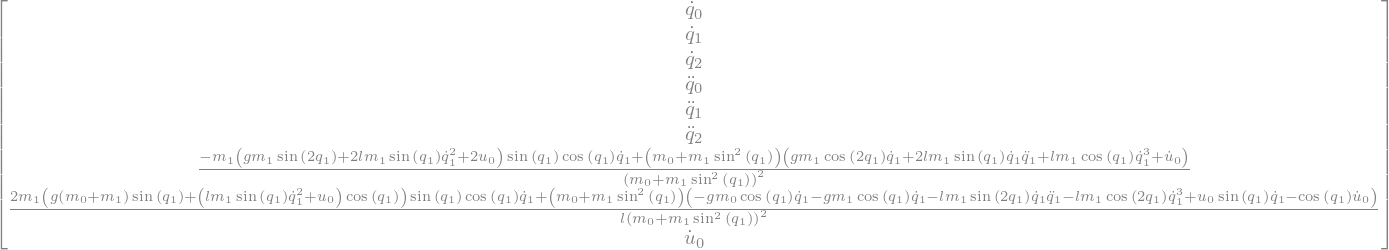

In [17]:
RHS_d_w = RHS_d_exp.row_insert(2, Matrix([q2d]))
RHS_d_w = RHS_d_w.row_insert(5, Matrix([q2dd]))
RHS_d_w = RHS_d_w.row_insert(8, Matrix([u0.diff()]))
RHS_d_w

In [18]:
RHS_d_w.shape

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [19]:
#Numerical values of the paramenters

m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [20]:
from chords.opti import Opti_Problem
import time
from functools import lru_cache

In [21]:
@lru_cache(maxsize=None)
def casadi_cartpole(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=LM_small,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _opti.initial_guess([0,0], [1,np.pi])
    _opti.u_sq_cost()
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    N = _opti.N
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [0, 0, 0, 0])
    opti.subject_to(X_e.T == [1, np.pi, 0, 0])
    
    # Appliying restrictions and action boundaries
    u_m = 20
    for ii in range(N):
        if 'parab' in scheme:
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [22]:
_res = casadi_cartpole('hs_mod_parab',25, 'lin', solve_repetitions=1,  silent=False, verbose=True)

Dynamics detected: Explicit Lagranges Method
Generating F function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]

Generating G function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	q: [q_0, q_1]
	v: [v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/I

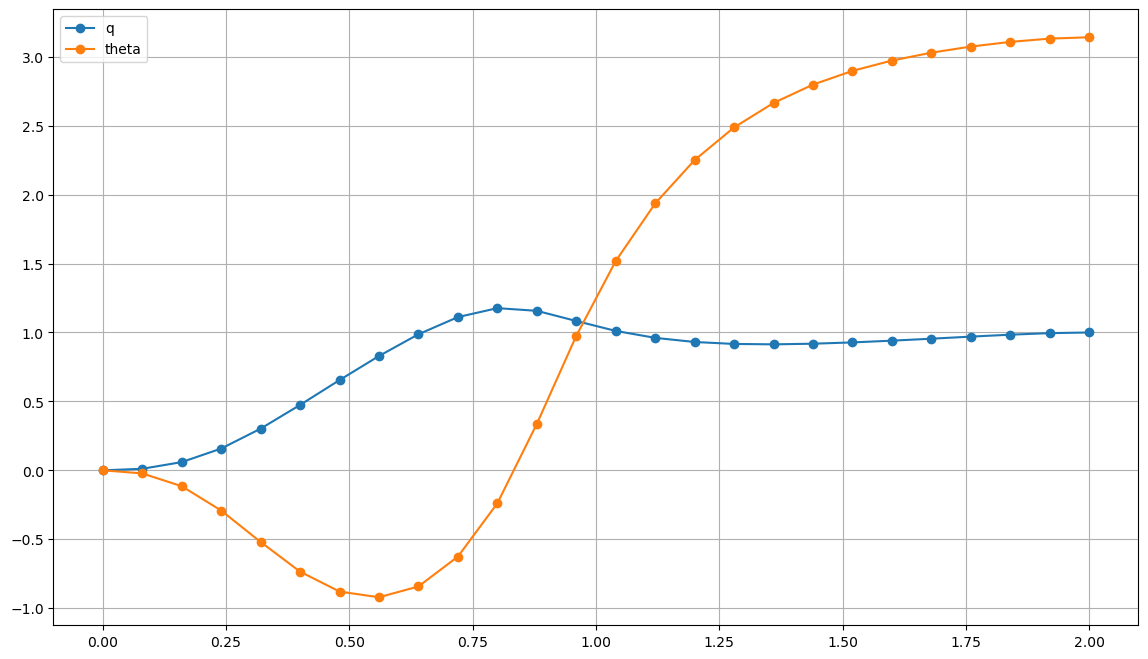

In [23]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', label = labels[ii])
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

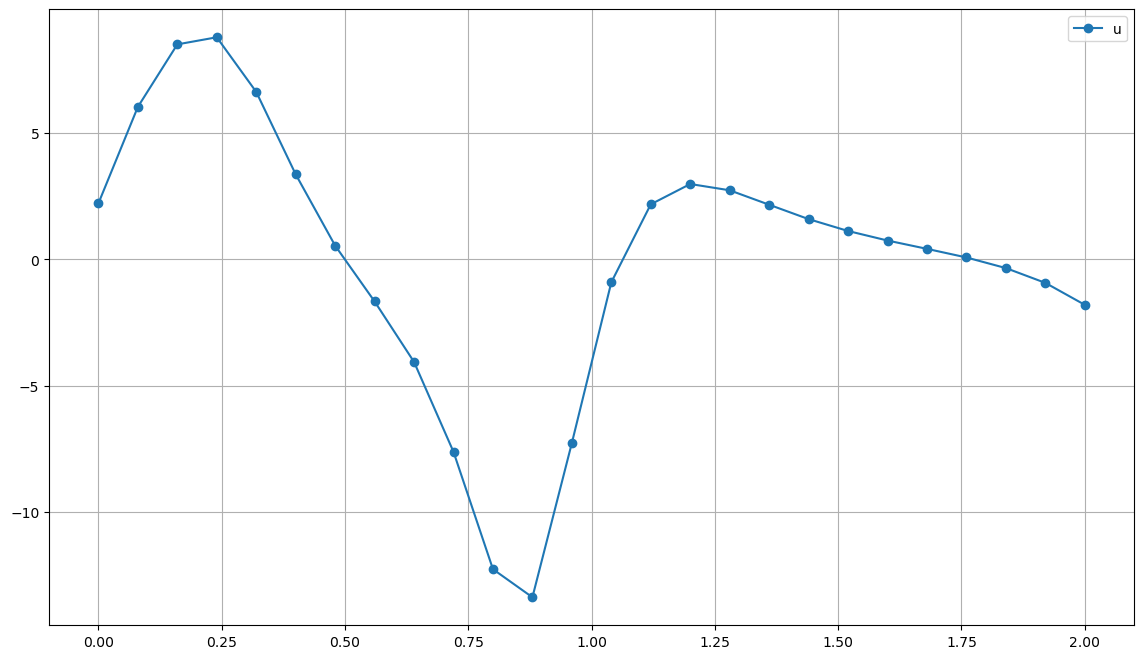

In [24]:
plt.figure(figsize=[14,8])
plt.plot(_res['t'],_res['u'][:], marker = 'o', label = 'u')
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

def gen_ini_guess(N = 25, ini_guess = 'lin'):
    '''
    Generates an initial guess for the Cartpole problem of N intervals.
    '''
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess


import time
def chrono_solve(opti, solve_repetitions):
    '''
    Calls the solver a certain amount of times and returns the last solution
    obtained and the average computing time
    '''
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


In [25]:
from chords.casadi import implicit_dynamic_x_to_casadi_function

In [26]:
x = dynamicsymbols('x_0:9')

In [27]:
x_d = [_i.diff() for _i in x]#symbols('\dot{x}_0:4')

In [28]:
RHSx=RHS_d_w.subs([
    [u0.diff(), u1],
    [u0, x[8]],
    [q0.diff(t,2), x[6]],
    [q1.diff(t,2), x[7]],
    [q2.diff(t,2), x[8]],
    [q0.diff(t), x[3]],
    [q1.diff(t), x[4]],
    [q2.diff(t), x[5]],
    [q0, x[0]],
    [q1, x[1]],
    [q2, x[2]]
])

RHS_small,RHSx

In [29]:
x_d_mat = Matrix(x_d)

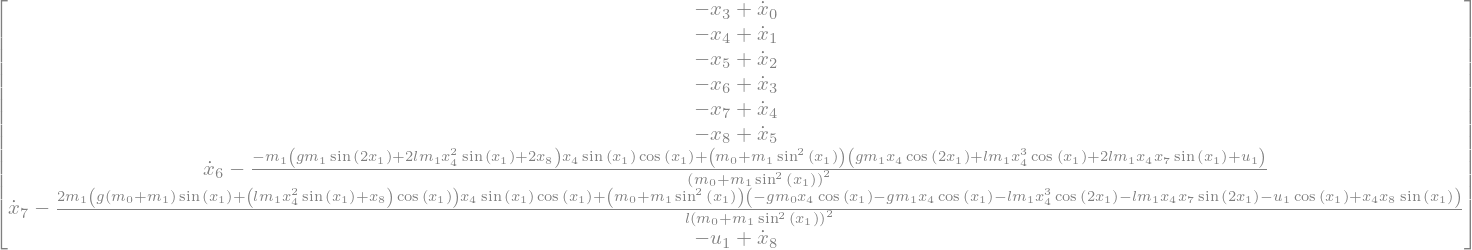

In [30]:
impl_D = x_d_mat-RHSx
impl_D

In [31]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(impl_D, x, verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
x vars found: [x_0_dot, x_1, x_1_dot, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot, x_6, x_6_dot, x_7, x_7_dot, x_8, x_8_dot]
u vars found: [u_1]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
	u: [u_1]
	lambdas: []
	params: [g, l, m_0, m_1]



Function(M:(x[9],x_dot[9],u,lambdas[0],params[4])->(residue[1x9]) MXFunction)

In [32]:
from chords.piecewise import interpolated_array, interpolated_array_derivative, reduce_F, hs_accel_restr
from chords.analysis import dynamic_error
from chords.numpy import RHS2numpy
from chords.casadi import rhs_to_casadi_function
import casadi as cas

In [33]:
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [34]:
G_nump = reduce_F(F_nump)

In [35]:
F_cas = rhs_to_casadi_function(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [36]:
G_cas = reduce_F(F_cas, mode='casadi')

def initial_cond_g(_op):
    X_s = _op.opti_points['x_s']
    opti = _op.opti
    a = X_s[:,6:8]
    q = X_s[:,:2]
    v = X_s[:,3:5]
    u = X_s[8]
    x = cas.horzcat(q,v)
    f = F_cas(x, u, params)
    g = f[:, 2:]
    opti.subject_to(a == g)

In [37]:
def initial_cond_g(_op):
    X_s = _op.opti_points['x_s']
    opti = _op.opti
    a = X_s[:,6:8]
    q = X_s[:,:2]
    v = X_s[:,3:5]
    u = X_s[:,8]
    g = G_cas(q, v, u, params)
    opti.subject_to(a == g)

In [56]:
_op = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = 'hs_parab',
        ini_guess= 'lin',
        t_end = 2,
        verbose=True,
        silent=False,
    )

Dynamics detected: Function


In [57]:
_op.dynamic_setup('f_x_impl', 3, 1, order=3)
_op.opti_setup(20)
_op.initial_guess([0,0,0], [1,np.pi,0])
#_op.sq_cost(_op.opti_arrs['x'][:,8], _op.opti_arrs['x_c'][:,8])
_op.u_sq_cost()
_op.apply_scheme()

In [58]:
opti = _op.opti
X = _op.opti_arrs['x']
U = _op.opti_arrs['u']
X_s = _op.opti_points['x_s']
X_e = _op.opti_points['x_e']

Q_s = X_s[:,:2]
V_s = X_s[:,3:5]
Q_e = X_e[:,:2]
V_e = X_e[:,3:5]
N = _op.N

# Initial and final conditions
opti.subject_to(Q_s.T == [0, 0])
opti.subject_to(Q_e.T == [1, np.pi])
opti.subject_to(V_s.T == [0, 0])
opti.subject_to(V_e.T == [0, 0])
initial_cond_g(_op)

# Appliying restrictions and action boundaries
u_m = 100
for ii in range(N):
    opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

_op.chrono_solve(solve_repetitions=2,)

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     3002
Number of nonzeros in inequality constraint Jacobian.:       21
Number of nonzeros in Lagrangian Hessian.............:      369

Total number of variables............................:      779
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      739
Total number of inequality constraints...............:       21
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       21
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.12e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [59]:
_res = _op.results

In [60]:
_op.opti_points

{'x_s': MX(opti2_x_1[:189:21]),
 'x_e': MX(opti2_x_1[20:209:21]),
 'x_d_s': MX(opti2_x_2[:189:21]),
 'x_d_e': MX(opti2_x_2[20:209:21]),
 'q_s': MX(opti2_x_1[:63:21]),
 'q_e': MX(opti2_x_1[20:83:21]),
 'v_s': MX(opti2_x_1[63:126:21]),
 'v_e': MX(opti2_x_1[83:146:21]),
 'a_s': MX(opti2_x_1[126:189:21]),
 'a_e': MX(opti2_x_1[146:209:21]),
 'jerk_s': MX(opti2_x_2[126:189:21]),
 'jerk_e': MX(opti2_x_2[146:209:21])}

In [61]:
print(_res['x'][:, 3:]-_res['x_d'][:, :6])
print(_res['x_c'][:, 3:]-_res['x_d_c'][:, :6])
print(_res['x_d'][:,6:] - _res['jerk'])
print(_res['x_d_c'][:,6:] - _res['jerk_c'])
print(_res['jerk_c'][:,2]-_res['u_c'], _res['jerk'][:,2]-_res['u'])
for ii in range(N):
    print(imp_F_x_cas(_res['x'][ii,:], _res['x_d'][ii,:], _res['u'][ii], [], params))
    print(imp_F_x_cas(_res['x_c'][ii,:], _res['x_d_c'][ii,:], _res['u_c'][ii], [], params))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 

In [62]:
_res['jerk'][ii+1,:]

array([-0.93446014, -1.86892028, -0.93446014])

In [63]:
dt = (_res['t'][-1]-_res['t'][0])/N
for ii in range(N):
    print(hs_accel_restr(
    _res['x'][ii,:],
    _res['x'][ii+1,:],
    _res['jerk'][ii],
    _res['jerk'][ii+1,:],
    dt,
    _res['jerk_c'][ii]
))

[-6.93889390e-18  1.38777878e-17  2.22044605e-16 -2.22044605e-16
  0.00000000e+00 -2.22044605e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[ 0.00000000e+00 -5.55111512e-17 -2.22044605e-16 -2.22044605e-16
  0.00000000e+00 -5.55111512e-17  8.88178420e-16 -8.88178420e-16
  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16 -4.44089210e-16  0.00000000e+00
  8.88178420e-16]
[ 0.00000000e+00  1.11022302e-16  0.00000000e+00 -4.44089210e-16
  0.00000000e+00  0.00000000e+00  1.11022302e-16  0.00000000e+00
  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00  2.22044605e-16  0.00000000e+00
 -1.04083409e-17  0.00000000e+00  0.00000000e+00 -3.55271368e-15
 -4.44089210e-16]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.88178420e-16 3.55271368e-15
 0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00 -2.08166817e-17  1.77635684e-15  3.5527

In [64]:
for ii in range(N):
    print(G_nump(_res['q'][ii,:2], _res['v'][ii,:2], _res['a'][ii,2], params)-_res['a'][ii,:2])

[0. 0.]
[-0.00200396  0.00624606]
[-0.00088564  0.00145272]
[ 0.00020523 -0.00175712]
[-0.00135048  0.00142406]
[-0.00115498 -0.00030697]
[-0.00182231  0.00067386]
[-0.01097764  0.03378761]
[ 0.07405576 -0.26736998]
[ 0.02692755 -0.11582303]
[ 0.03392503 -0.11991149]
[ 0.03202408 -0.10741241]
[ 0.03079567 -0.10980508]
[ 0.03079744 -0.1101625 ]
[ 0.03097087 -0.10968888]
[ 0.03102872 -0.10951029]
[ 0.03103815 -0.10948067]
[ 0.03103876 -0.10947621]
[ 0.03104454 -0.10945148]
[ 0.03104175 -0.10946226]


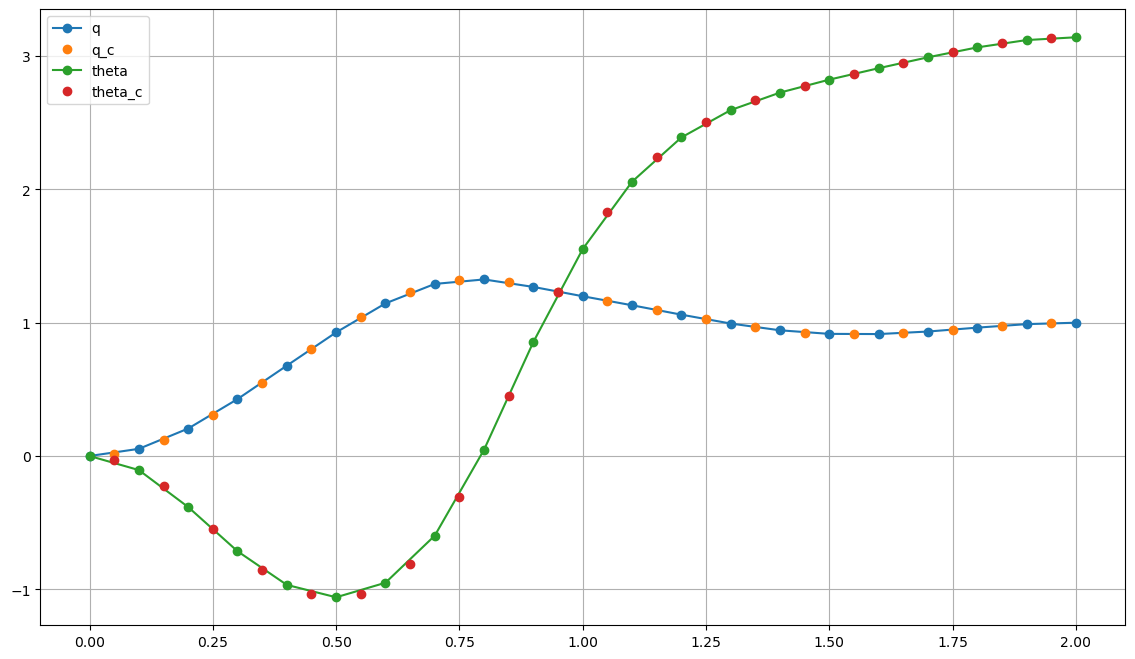

In [65]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', label = labels[ii])
    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.grid()
plt.legend()

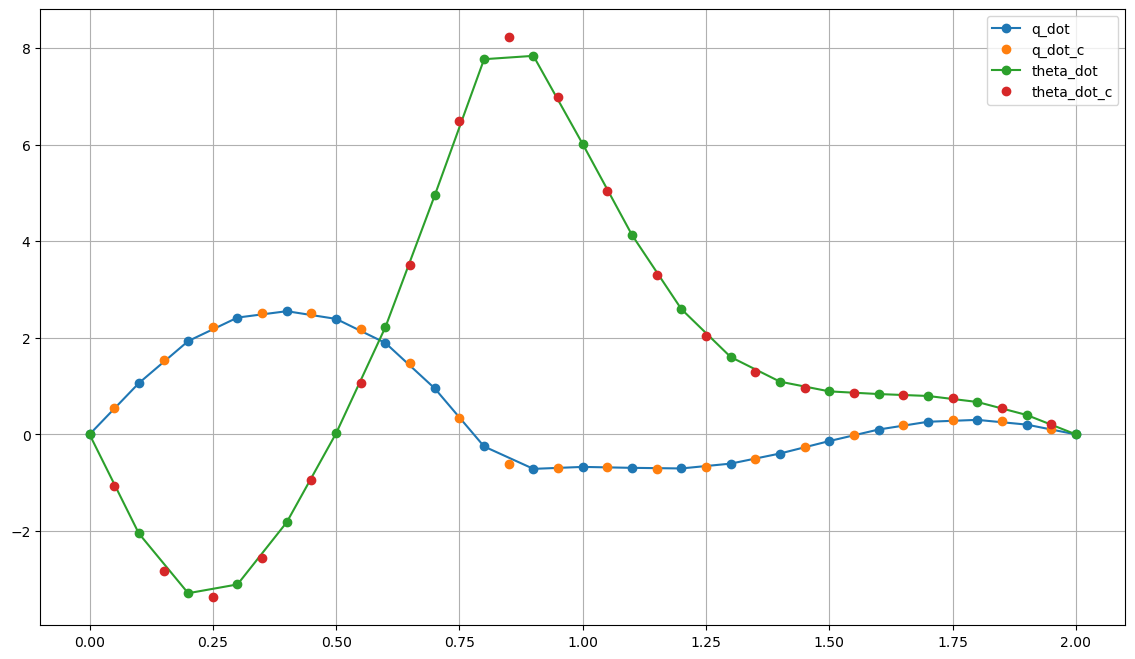

In [66]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
for ii in range(2):
    plt.plot(_res['t'],_res['v'][:,ii], marker = 'o', label = labels[ii])
    plt.plot(_res['t_c'],_res['v_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.grid()
plt.legend()

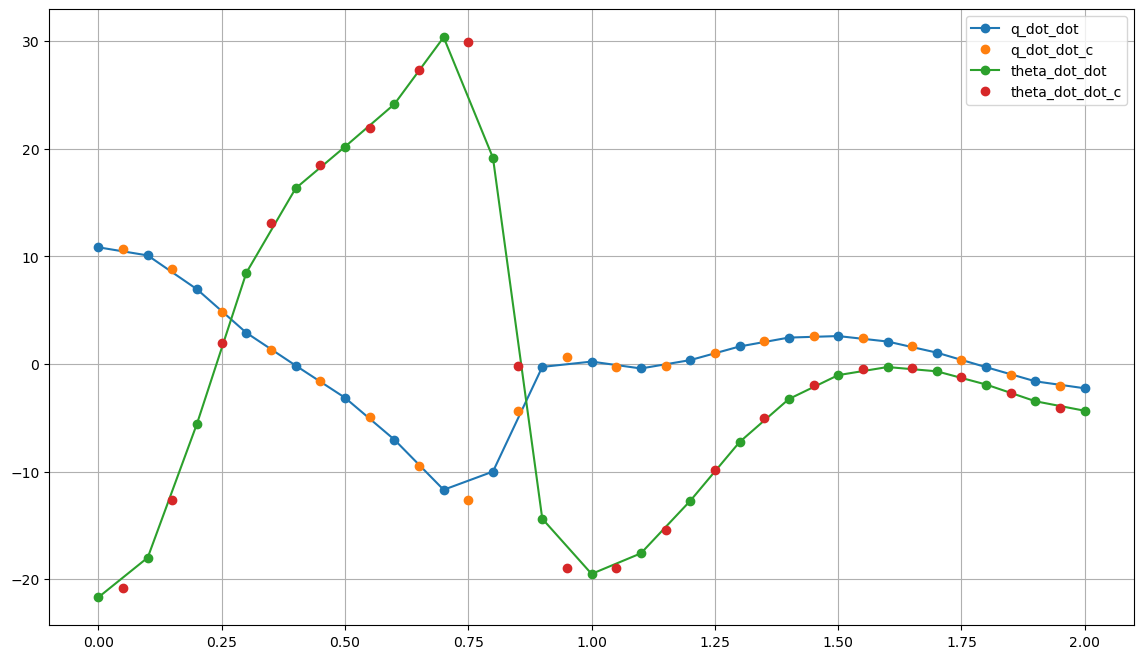

In [67]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(_res['t'],_res['a'][:,ii], marker = 'o', label = labels[ii])
    plt.plot(_res['t_c'],_res['a_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.grid()
plt.legend()

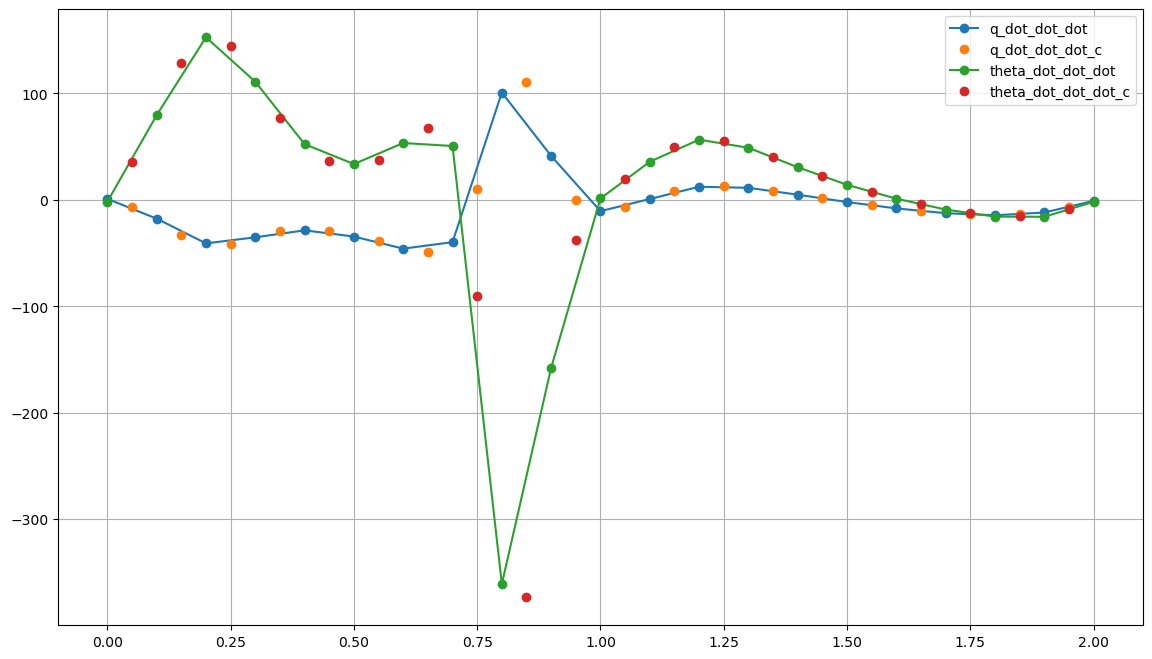

In [68]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot_dot', 'theta_dot_dot_dot']
for ii in range(2):
    plt.plot(_res['t'],_res['jerk'][:,ii], marker = 'o', label = labels[ii])
    plt.plot(_res['t_c'],_res['jerk_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.grid()
plt.legend()

In [69]:
_res.keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'x', 'x_d', 'u', 't', 'lam', 'q', 'v', 'a', 'jerk', 'x_c', 'x_d_c', 'u_c', 't_c', 'lam_c', 'q_c', 'v_c', 'a_c', 'jerk_c'])

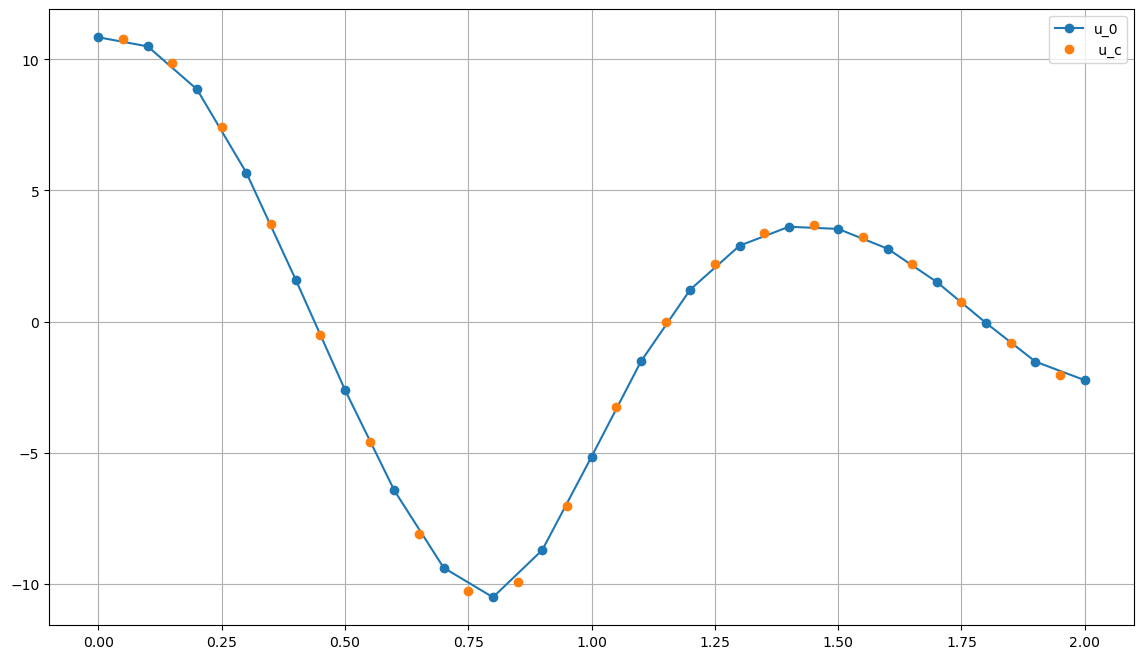

In [70]:
plt.figure(figsize=[14,8])
for ii in [2]:
    plt.plot(_res['t'],_res['a'][:,ii], marker = 'o', label = 'u_0')
    plt.plot(_res['t_c'],_res['a_c'][:,ii], 'o', label = ' u_c')
plt.grid()
plt.legend()

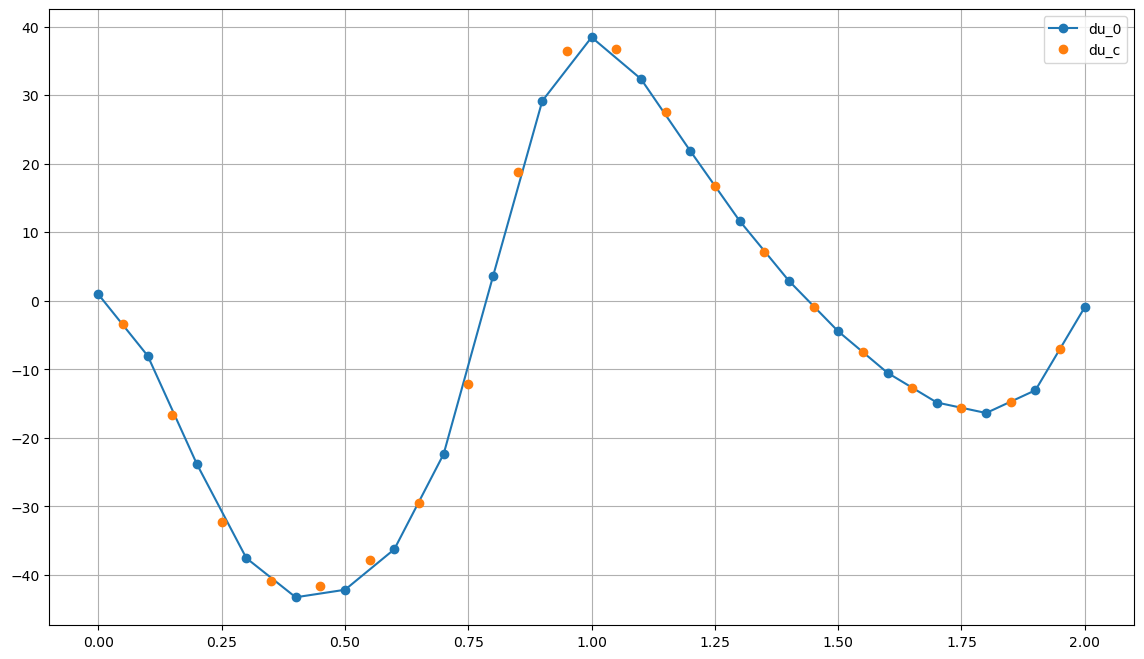

In [71]:
plt.figure(figsize=[14,8])
for ii in [2]:
    plt.plot(_res['t'],_res['jerk'][:,ii], marker = 'o', label = 'du_0')
    plt.plot(_res['t_c'],_res['jerk_c'][:,ii], 'o', label = 'du_c')
plt.grid()
plt.legend()

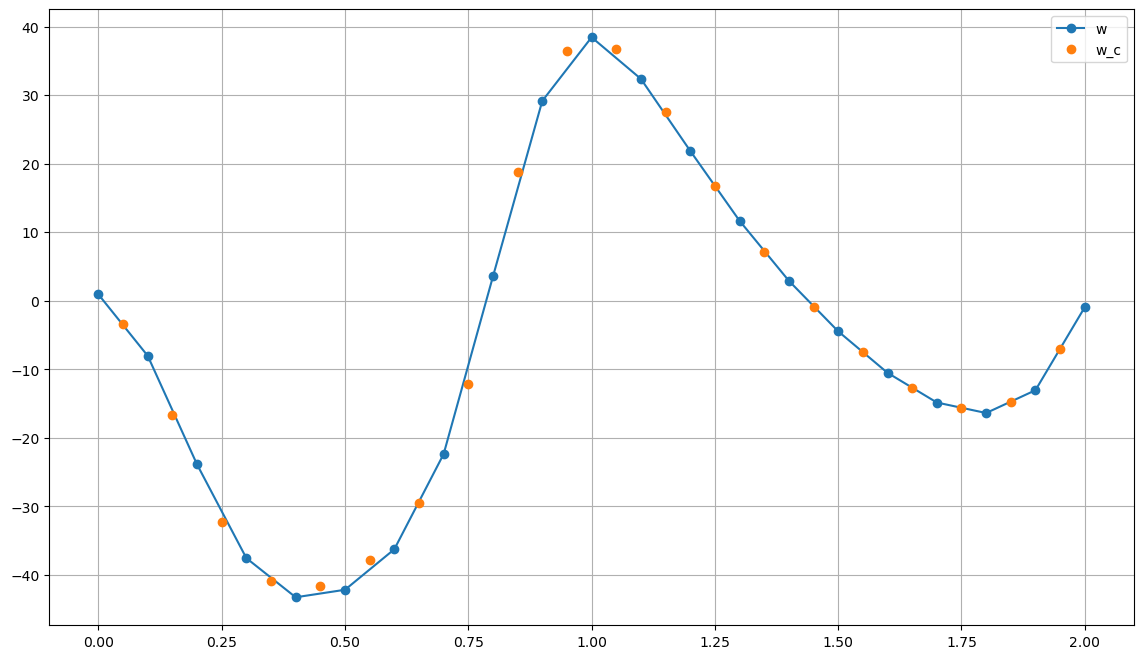

In [72]:
plt.figure(figsize=[14,8])
plt.plot(_res['t'],_res['u'][:], marker = 'o', label = 'w')
plt.plot(_res['t_c'],_res['u_c'][:], 'o', label = 'w_c')
plt.grid()
plt.legend()

In [73]:
_res['x'][0]

array([ 0.00000000e+00, -1.12111612e-38,  1.18228628e+00,  0.00000000e+00,
        0.00000000e+00, -1.79824062e+00,  1.08384509e+01, -2.16769018e+01,
        1.08384509e+01])

#@lru_cache
def casadi_cartpole(N = 25, scheme = 'euler', ini_guess = 'lin', solve_repetitions = 1, t_end = 2):
    opti = cas.Opti()
    p_opts = {"expand":True,'ipopt.print_level':0, 'print_time':0}
    s_opts = {"max_iter": 10000, 'tol': 1e-26}
    opti.solver("ipopt",p_opts,
                        s_opts)
    restr_schemes = {
        'euler': euler_restr, # Euler scheme
        'trapz': trapz_restr, # Trapezoidal Scheme
        'trapz_mod' : trapz_mod_restr, # Second Order Trapezoidal Scheme
        'hs': hs_restr, # Hermite Simpson Scheme, assuming that each Uc is the central value
        'hs_mod': hs_mod_restr, # Second Order Hermite Simpson Scheme, assuming that each Uc is the central value
        'hs_parab': hs_parab_restr, # Hermite Simpson Scheme, with Uc as a free problem parameter
        'hs_mod_parab': hs_mod_parab_restr # Second Order Hermite Simpson Scheme, with Uc as a free problem parameter
        #'your scheme name here': your_scheme_function_here
    }
    
    f_restr = restr_schemes[scheme]
    
    # parab is a boolean variable that controls wether the centran points of U are free decision variables
    if scheme in ['hs_parab', 'hs_mod_parab']:
        parab = True
    else:
        parab = False
        
    # Creating problem structure
    X = opti.variable(N+1,4)
    U = opti.variable(N+1)
    if parab:
        U_c = opti.variable(N)
    T = opti.parameter()
    u_m = opti.parameter()
    Params = opti.parameter(4)

    # Defining the problem cost to minimize (integral of u^2)
    cost = (cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/N
    if parab:
        cost = (4*cas.sum1(U_c[:]**2) + cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/(3*N)
    opti.minimize(cost)

    # Initial and final conditions
    opti.subject_to(X[0,:].T == [0, 0, 0, 0])
    opti.subject_to(X[-1,:].T == [1, np.pi, 0, 0])
    
    # Translating the scheme restriction function into a CasADi function
    if parab: 
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4, 1)
    else:
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4)

    # Appliying restrictions and action boundaries
    for ii in range(N):
        if parab:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1],T/N, Params, U_c[ii])==0)
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        else:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1,:],T/N, Params)==0)
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    
    # Setting parameters to their numeric values
    opti.set_value(T, t_end)
    max_f = 20.0
    opti.set_value(u_m, max_f)

    m0_n, m1_n = [1., 0.3]
    l_n = 0.5
    g_n = 9.81
    opti.set_value(Params, [g_n, l_n, m0_n, m1_n])
    
    # Setting the initialization values
    if ini_guess in ['zero', 'lin']:
        opti.set_initial(X, gen_ini_guess(N, ini_guess))
    elif type(ini_guess) == list:
        opti.set_initial(X, ini_guess[0])
        opti.set_initial(U, ini_guess[1])
        if parab:
            opti.set_initial(U_c, ini_guess[2])
    else:
        raise TypeError('initial guess not understood')
      
    # Solve
    sol, cpudt = chrono_solve(opti, solve_repetitions)
    err_count = None
    sol_cost = sol.value(cost)
    xx_simp = sol.value(X)
    uu_simp = sol.value(U)
    if parab:
        uu_c = sol.value(U_c)
    else:
        uu_c = None
        
    # Return data
    return xx_simp, uu_simp, uu_c, cpudt, err_count, sol_cost

Let's try to solve the problem for 25 points and the 2nd order Hermite Simpson

scheme = 'hs_mod_parab'
N = 25
xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, 'lin', 1)

xx_interp, uu_interp = interpolated_array(
    X = xx,
    U = uu,
    F = F_nump,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Toputto',
        'hs_mod': 'HS-2-Toputto',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2'
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Toputto)',
          '2nd order Hermite Simpson (Toputto)',]
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod']
    lname_dict = {}
    for ii in range(6):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate(['hs_parab', 'trapz_mod', 'trapz', 'hs_mod_parab','hs', 'hs_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False):
    kwargs = {'marker' :'o', 'c':sch_to_color(sch)}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

In [33]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [34]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod'] #If you defined a custom function, name your scheme here
initials = ['lin']
solve_repetitions = 10 #Increase this number to get more reliable values of execution times
N_arr = [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]# You can increase the numbers here, but it will take more time
results = {}

for scheme in schemes:
    key = scheme
    print('Problem:', key)
    results[key] = {'N_arr':N_arr}
    for N in N_arr:
        print(f'\tN = {N} , ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        results[key][N] = casadi_cartpole(
            scheme,
            N, 
            'lin',
            solve_repetitions=solve_repetitions,
            silent=True, 
            verbose=False)


Problem: hs_parab
	N = 20 ,  16:58:29 
	N = 25 ,  16:58:30 
	N = 30 ,  16:58:30 
	N = 40 ,  16:58:31 
	N = 50 ,  16:58:32 
	N = 60 ,  16:58:32 
	N = 80 ,  16:58:33 
	N = 100 ,  16:58:35 
	N = 120 ,  16:58:37 
	N = 160 ,  16:58:39 
	N = 200 ,  16:58:42 
Problem: hs_mod_parab
	N = 20 ,  16:58:45 
	N = 25 ,  16:58:46 
	N = 30 ,  16:58:46 
	N = 40 ,  16:58:47 
	N = 50 ,  16:58:48 
	N = 60 ,  16:58:48 
	N = 80 ,  16:58:49 
	N = 100 ,  16:58:51 
	N = 120 ,  16:58:53 
	N = 160 ,  16:58:55 
	N = 200 ,  16:58:57 
Problem: trapz
	N = 20 ,  16:59:01 
	N = 25 ,  16:59:01 
	N = 30 ,  16:59:02 
	N = 40 ,  16:59:02 
	N = 50 ,  16:59:02 
	N = 60 ,  16:59:03 
	N = 80 ,  16:59:03 
	N = 100 ,  16:59:04 
	N = 120 ,  16:59:05 
	N = 160 ,  16:59:06 
	N = 200 ,  16:59:07 
Problem: trapz_mod
	N = 20 ,  16:59:09 
	N = 25 ,  16:59:09 
	N = 30 ,  16:59:09 
	N = 40 ,  16:59:09 
	N = 50 ,  16:59:10 
	N = 60 ,  16:59:10 
	N = 80 ,  16:59:11 
	N = 100 ,  16:59:11 
	N = 120 ,  16:59:12 
	N = 160 ,  16:59:13 
	N = 200

In [35]:
#Calculating the number of collocation points
for scheme in results.keys():
    if 'hs' in scheme:
        n_coll = np.array(results[scheme]['N_arr'])*2-1
        results[scheme]['N_coll_arr'] = n_coll
    else:
        results[scheme]['N_coll_arr'] = results[scheme]['N_arr']

In [36]:
for scheme in schemes:
    key = scheme
    _c = []
    _cpudt = []
    _iters = []
    for N in results[key]['N_arr']:
        _c.append(results[key][N]['cost'])
        _cpudt.append(results[key][N]['cpudt'])
        _iters.append(results[key][N]['iter_count'])
    results[key]['cost'] = np.array(_c)
    results[key]['cpudt'] = np.array(_cpudt)
    results[key]['iter_count'] = np.array(_iters)

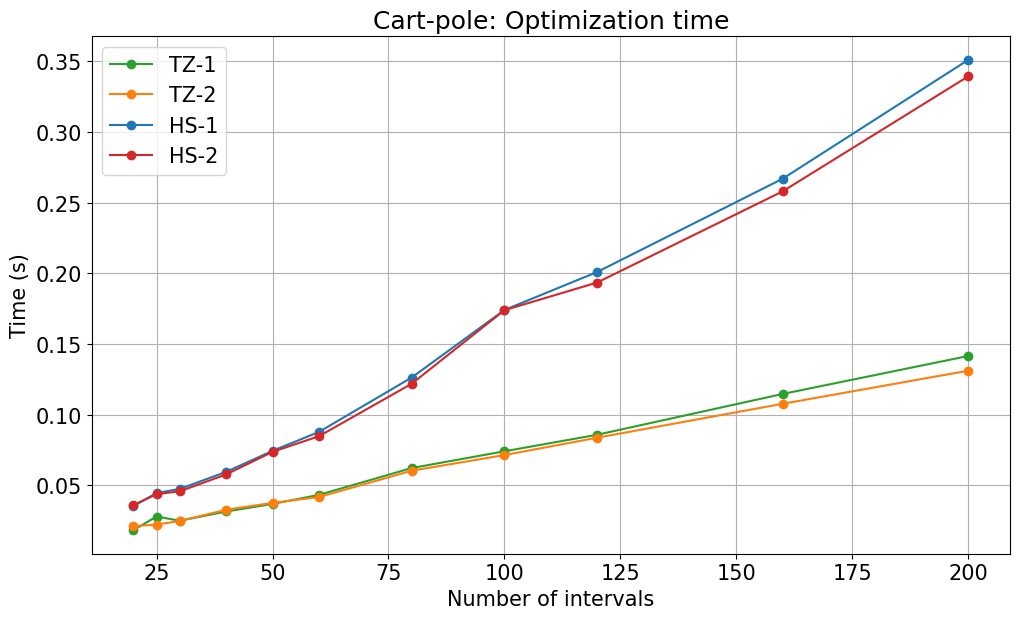

In [57]:
#titles = ['LG','LG2']#'D2', 'LGL', 
schemes =['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab',]
plt.figure(figsize=oct_fig_size)
for ii in range(len(schemes)):
    key = schemes[ii]
    plt.plot(
        results[key]['N_arr'],
        results[key][f'cpudt'],
        **scheme_kwargs(key, longlabel=False)
    )
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Cart-pole: Optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
#plt.savefig('2d_order/5_link_optimization_vs_interval_number.pdf', format='pdf')

Text(0.5, 1.0, 'Final traj cost')

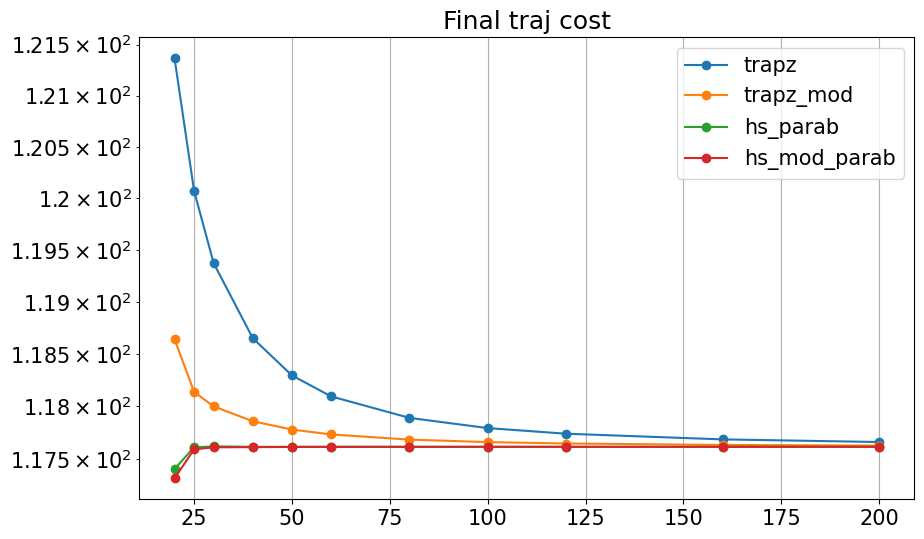

In [38]:
plt.figure(figsize=oct_fig_size)
for scheme in schemes:
    key = scheme
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], marker = 'o', label = scheme)
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [39]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

from chords.piecewise import (
    interpolated_array,
    interpolated_array_derivative,
    _newpoint,
    interp_2d,
    _newpoint_der,
    _newpoint_u,
    _calculate_missing_arrays,
    get_x_divisions,
    vec_len,
)
from scipy.optimize import root, minimize
from scipy.integrate import quad
from functools import lru_cache
from numpy import (
    zeros,
    zeros_like,
    append,
    concatenate,
    linspace,
    expand_dims,
    interp,
    array,
    sum,
    abs,
    max,
    sqrt,
    trapz,
)
from numpy.linalg import inv, solve
from scipy.interpolate import CubicHermiteSpline as hermite
from copy import copy
import warnings

def dynamic_error(
    x_arr,
    u_arr,
    t_end,
    params,
    F,
    X_dot=None,
    scheme="hs_scipy",
    u_scheme="lin",
    scheme_params={},
    n_interp=2000,
    order = 2,
    mode = 'q',
):
    """
    Generate arrays of equispaced points with values of dynamic error.

    If x(t) = [q(t), v(t)], and the physics equation states that x' = F(x, u),
    which is equivalent to [q', v'] = [v , G(q, v, u)] we can define the
    dynamic errors at a point t as:
        dyn_q_err = q'(t) - v(t)
        dyn_v_err = v'(t) - G(q(t), v(t), u(t))
        dyn_2_err_a = q''(t) - G(q(t), v(t), u(t))
        dyn_2_err_b = q''(t) - G(q(t), q'(t), u(t))

    'scheme' and 'u_scheme' define the way in which we interpolate the values
    of q, v and u between the given points.

    It is assumed that X and U start at t = 0 and are equispaced in time
    in the interval (0, t_end).


    Parameters
    ----------
    x_arr : Numpy Array, shape = (W, 2N)
        Values known of x(t)
    u_arr : Numpy Array, shape = (W, [Y])
        Values known of u(t)
    t_end : float
        ending time of interval of analysis
    params : list
        Physical problem parameters to be passed to F
    F : Function of (x, u, params)
        A function of a dynamic sistem, so that
            x' = F(x, u, params)
        if X_dot is None and F is not, F will be used to calculate X'
    X_dot : Numpy Array, optional, shape = (W, 2N), default = None
        Known values of X'
        if X_dot is None, F will be used to calculate X'
    scheme : str, optional
        Scheme to be used in the X interpolation. The default is "hs_scipy".
        Acceptable values are:
            "trapz" : trapezoidal scheme compatible interpolation (not lineal!)
            "trapz_mod": modified trapezoidal scheme compatible interpolation (not lineal!)
            "hs_scipy": 3d order polynomial that satisfies continuity in x(t) and x'(t)
            "hs": Hermite-Simpson scheme compatible interpolation
            "hs_mod": modified Hermite-Simpson scheme compatible interpolation
            "hs_parab": Hermite-Simpson scheme compatible interpolation with parabolic U
            "hs_mod_parab": modified Hermite-Simpson scheme compatible interpolation with parabolic U
            "hsj":Hermite-Simpson-Jacobi scheme compatible interpolation
            "hsj_parab":Hermite-Simpson-Jacobi scheme compatible interpolation with parabolic U
    u_scheme : string, optional
        Model of the interpolation that must be used. The default is "lin".
        Acceptable values are:
            "lin": lineal interpolation
            "parab": parabolic interpolation, requires central points array
            as scheme params[0]
            "parab_j": parabolic interpolation, with the intermediate point
            at 2h/5, for work with HSJ. Requires central points array
            as scheme params[0]
    scheme_params :dict, optional
        Aditional parameters of the scheme. The default is {}.
    n_interp : int, optional
        Number of interpolation points. The default is 2000.
    order : int, default 2
        differential order of the problem
    mode : str, 'q' or 'x', default 'q'.
        if 'q': q and its derivatives will be used in G, such as:
            G(q(t), q'(t). u(t))
        if 'x': components of x will be used in G, such as:
            G(q(t), v(t), u(t))

    Returns
    -------
    dyn_errs: list of lists of arrs that contain the dynamic errors
        A list of [order] items, the n-th item is a list of the n-th dynamic errors.
        First item is the list (first order errors):
            [q' - v,
             v' - a,
             ...
             x'[last] - f,]
        last item in the list (highest order errors):
            [q^(order) - f,]

    """
    if "parab" in scheme and u_scheme == "lin":
        warnings.warn(
            "You are currently using a u-parabolic interpolation for x with a lineal interpolation of u"
        )
    if "parab" in u_scheme and "parab" not in scheme:
        warnings.warn(
            "You are currently using a parabolic interpolation for u with a non u-parabolic interpolation of x"
        )
    if ("j" in u_scheme and "j" not in scheme) or (
        "j" not in u_scheme and "j" in scheme
    ):
        warnings.warn(
            f"Scheme {scheme} incompatible with u_scheme{u_scheme}"
            + ", 'parab_j' must be used with 'hsj'."
        )
    N = x_arr.shape[0] - 1
    dim = x_arr.shape[1] // order
    h = t_end / N
    t_interp = linspace(0, t_end, n_interp)
    x_and_derivs = []
    x_interp, u_interp = interpolated_array(
        x_arr,
        u_arr,
        h,
        t_interp,
        params,
        X_dot=X_dot,
        F=F,
        scheme=scheme,
        u_scheme=u_scheme,
        scheme_params=scheme_params,
    )
    
    print(f'x_interp_shape: {x_interp.shape}, vec_len:{vec_len(x_interp)}, len:{len(x_interp)}')
    
    x_and_derivs.append(get_x_divisions(x_interp, order))
    for jj in range(1, order+1):
        x_and_derivs.append(get_x_divisions(interpolated_array_derivative(
            x_arr,
            u_arr,
            h,
            t_interp,
            params,
            F=F,
            X_dot=X_dot,
            scheme=scheme,
            order=jj,
            scheme_params=scheme_params,
        ), order))
        
        
    for ii,element in enumerate(x_and_derivs):
        for jj,cosa in enumerate(element):
            print(f'deriv_order {ii}, array {jj}: tamaño {cosa.shape}')
            
            
    q_and_d_interp = copy(x_interp)
    for jj in range(order):
        q_and_d_interp[:, dim*jj: dim*(jj+1)] = x_and_derivs[jj][0]
        
    if mode == 'q':
        x_in_f = q_and_d_interp
    elif mode == 'x':
        x_in_f = x_interp
    else:
        raise ValueError(f"Value of mode {mode} not valid. Valid values are 'q' and 'x'.")
        
    f_interp = zeros([n_interp, dim])
    for ii in range(n_interp):
        f_interp[ii, :] = F(x_in_f[ii], u_interp[ii], params)[dim:]
    x_and_derivs[0].append(f_interp)
    
    dyn_errs = []
    for jj in order:
        dyn_errs_order = []
        for ii in range(order-jj):
            dyn_errs_order.append(x_and_derivs[jj+1][ii] - x_and_derivs[0][ii+jj+1])
        dyn_errs.append(dyn_errs_order)
    return dyn_errs

In [40]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod']
n_interp = 2000
for scheme in schemes:
    key = scheme 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        if 'parab' in scheme:
            u_scheme = 'parab'
            sch_param = {'u_c':results[key][N]['u_c']}
        else:
            u_scheme = 'lin'
            sch_param = {}
        dynamic_errors = dynamic_error(
            results[key][N]['x'],
            results[key][N]['u'],
            2,
            params,
            F_nump,
            scheme = scheme,
            u_scheme= u_scheme,
            scheme_params= sch_param,
            n_interp = n_interp)
        dyn_err_q = dynamic_errors[0][0]
        dyn_err_v = dynamic_errors[0][1]
        dyn_err_2 = dynamic_errors[1][0]
        results[key][N]['dyn_err_q'] = dyn_err_q
        results[key][N]['dyn_err_v'] = dyn_err_v
        results[key][N]['dyn_err_2'] = dyn_err_2
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        results[key][N]['err_q_int'] = dyn_err_q
        results[key][N]['err_v_int'] = dyn_err_v
        results[key][N]['err_2_int'] = dyn_err_2
        results[key][N]['err_q'] = tot_dyn_err_q
        results[key][N]['err_v'] = tot_dyn_err_v
        results[key][N]['err_2'] = tot_dyn_err_2
            

Problem: hs_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hs_mod_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_mod
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


In [41]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [42]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_v_acum = []
    err_2_acum = []
    cpudt = []
    for N in N_arr:
        err_q_acum.append(results[key][N]['err_q'])
        err_v_acum.append(results[key][N]['err_v'])
        err_2_acum.append(results[key][N]['err_2'])
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
    results[key]['err_2_acum'] = np.array(err_2_acum, dtype = float)
    

Problem: hs_parab
Problem: hs_mod_parab
Problem: trapz
Problem: trapz_mod


In [43]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_2'].shape[0])
        
        if 'hs' in key:
            scheme_params={'u_c':_case['u_c'],
                          'x_dot_c': _case['x_d_c'],
                          'x_c': _case['x_c']}
        else:
            scheme_params={}
            
        _derivs = interpolated_array_derivative(
            _case['x'],
            _case['u'],
            _case['t'][-1]/(_case['t'].shape[0]-1),
            t_array = t_arr,
            params=params,
            F=None,
            X_dot=_case['x_d'],
            scheme=key,
            order=1,
            scheme_params=scheme_params,)
        _accels = _derivs[:, 2:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_2_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_2_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_2']/_case['a_arr'])
        _case['rel_dyn_err_2_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_2_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_2']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_2_arr_by_a_sum_arr_sum'] = None

Problem: hs_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hs_mod_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_mod
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

In [44]:
from chords.util import plot_by_segments

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [45]:
results[key][N].keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'x', 'x_d', 'u', 't', 'lam', 'q', 'v', 'a', 'dyn_err_q', 'dyn_err_v', 'dyn_err_2', 'err_q_int', 'err_v_int', 'err_2_int', 'err_q', 'err_v', 'err_2', 'sum_dyn_err_2_arr', 'a_arr', 'a_abs_mean_by_component', 'a_abs_mean', 'a_abs_sum_arr', 'rel_dyn_err_2_arr_by_instant_a_sum', 'rel_dyn_err_2_arr_by_total_mean_sum', 'rel_dyn_err_2_arr_by_mean_by_component_sum', 'rel_dyn_err_2_arr_by_a_sum_arr_sum'])

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


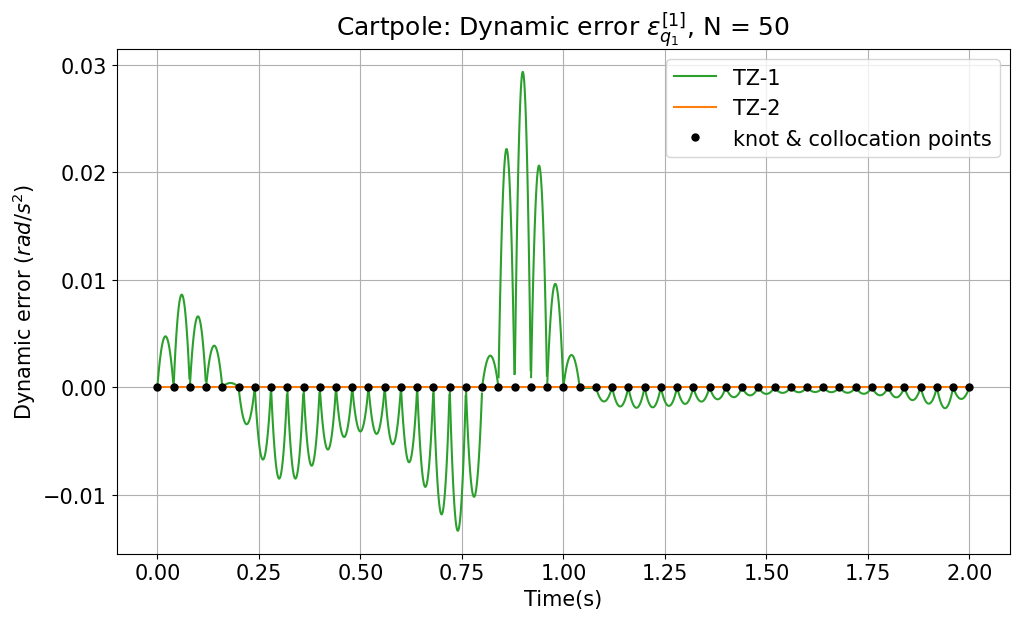

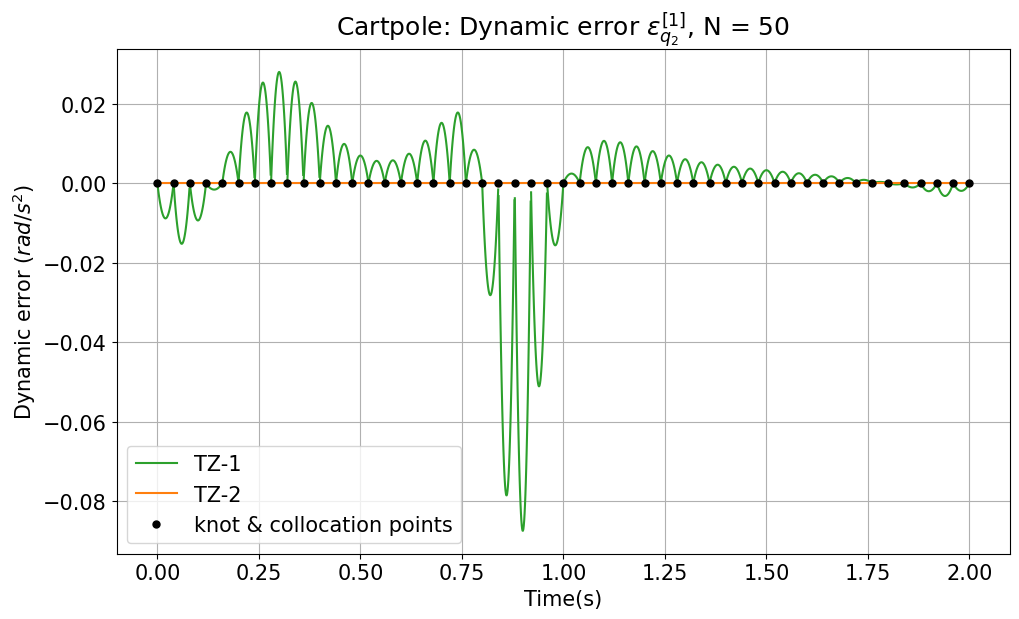

In [46]:
schemes = ['trapz', 'trapz_mod']
N = 50
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_q',
        title = r'Cartpole: Dynamic error $\varepsilon^{[1]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_First_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


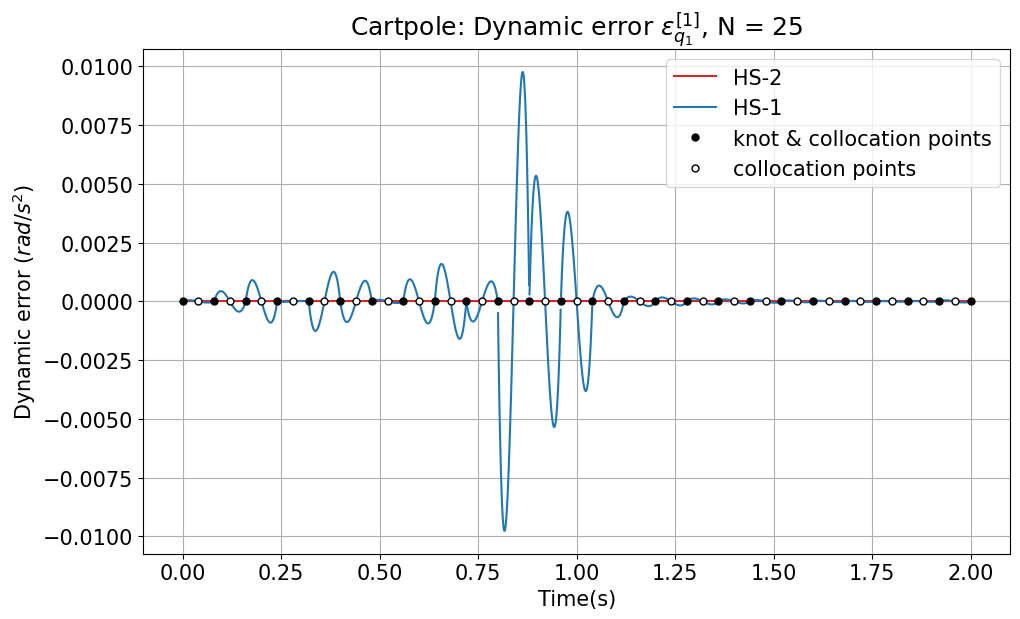

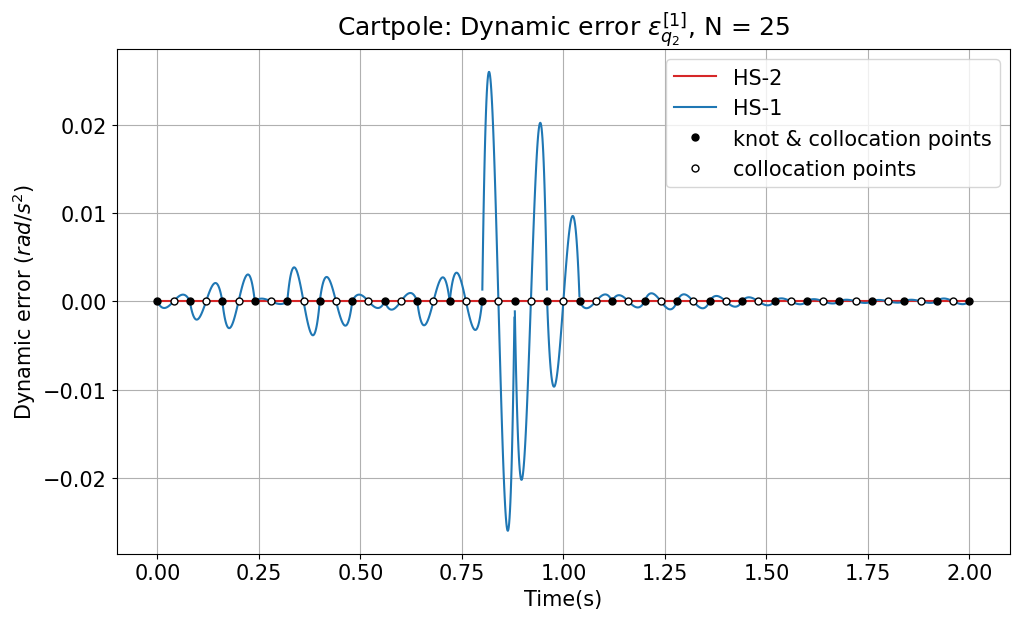

In [47]:
schemes = ['hs_mod_parab','hs_parab']
N = 25
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_q',
        title = r'Cartpole: Dynamic error $\varepsilon^{[1]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_First_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


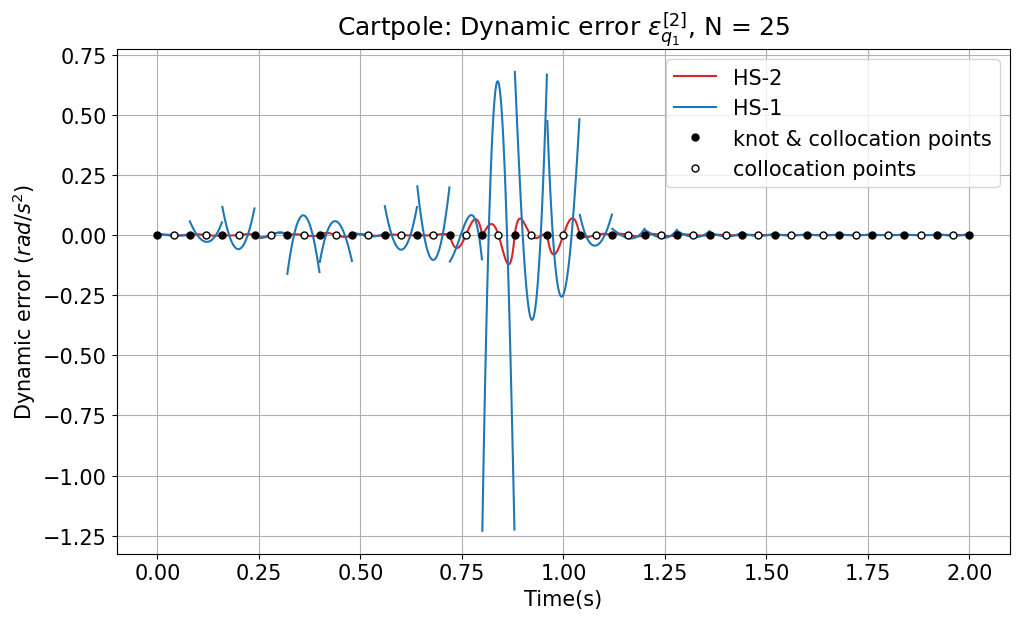

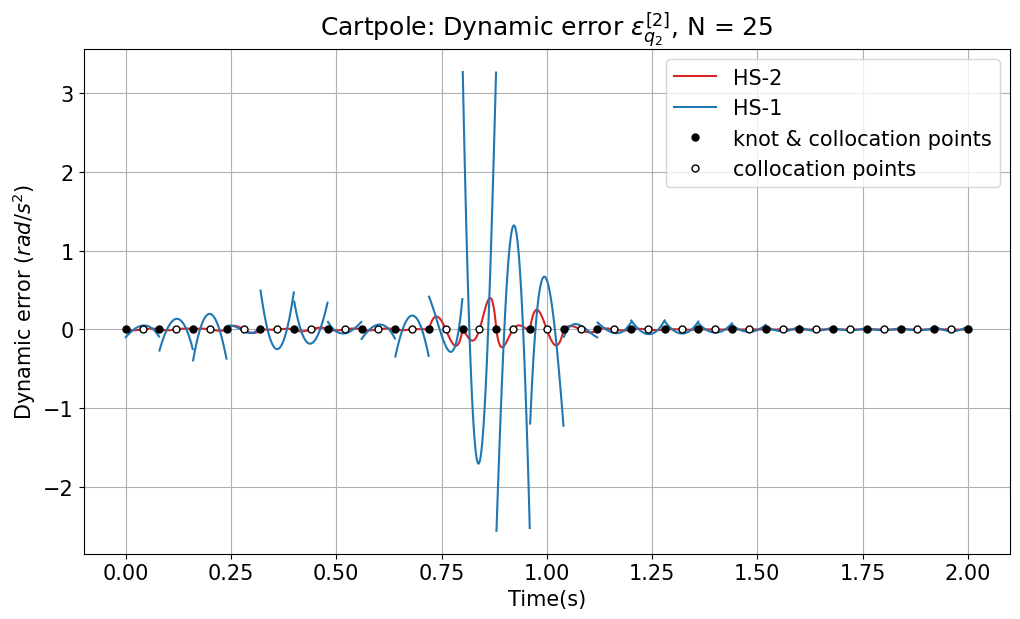

In [48]:
schemes = ['hs_mod_parab','hs_parab']
N = 25
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_2',
        title = r'Cartpole: Dynamic error $\varepsilon^{[2]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_Second_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


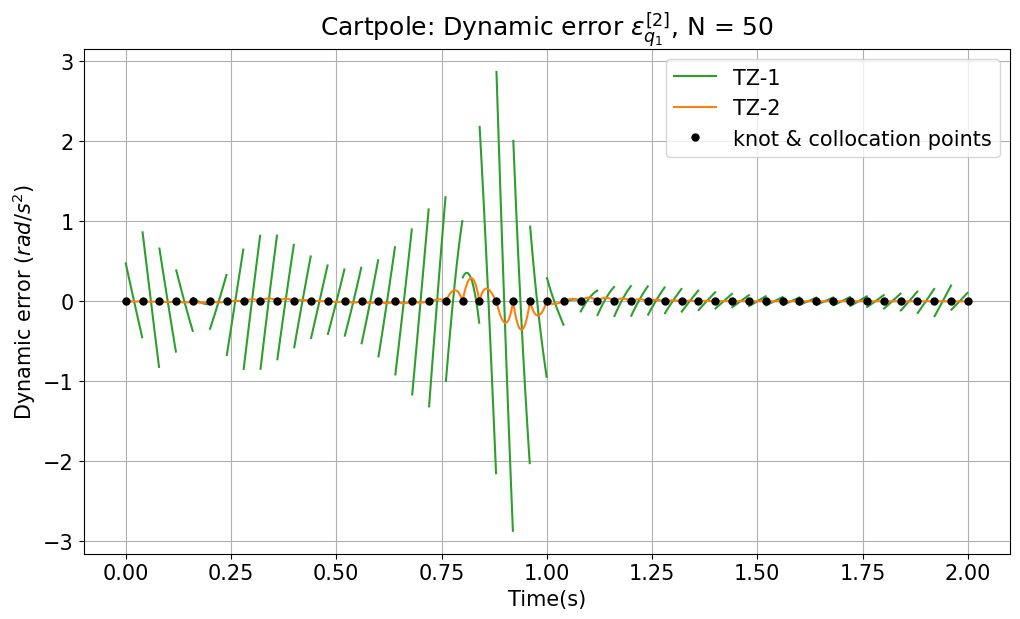

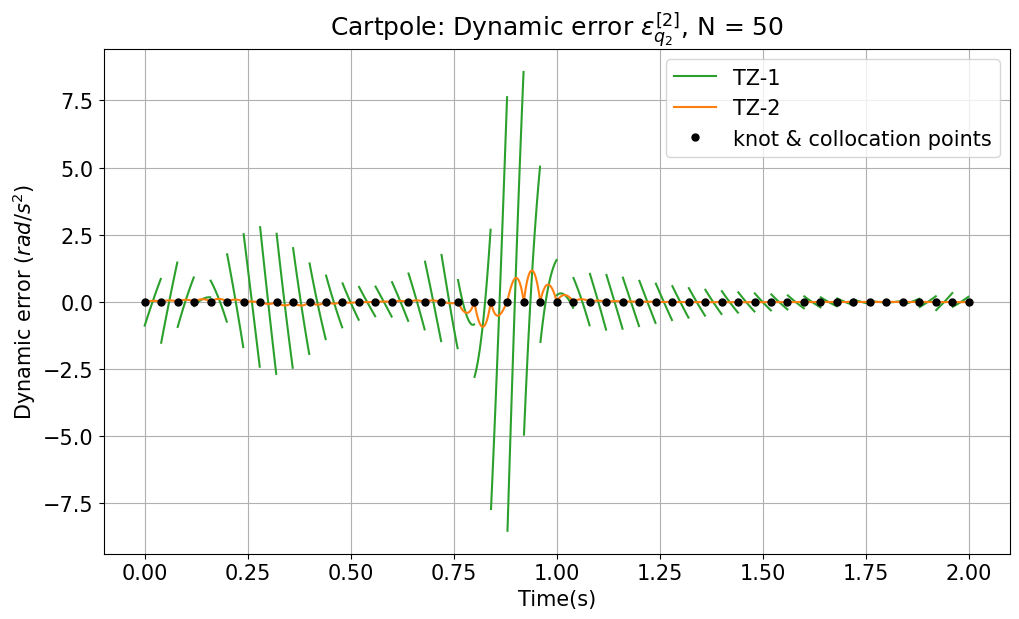

In [49]:
schemes = ['trapz', 'trapz_mod']
N = 50
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_2',
        title = r'Cartpole: Dynamic error $\varepsilon^{[2]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_Second_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

#### Relative Errors

In [50]:
error_types = ['rel_dyn_err_2_arr_by_instant_a_sum',
 'rel_dyn_err_2_arr_by_mean_by_component_sum',]
error_titles = [error.replace('rel_dyn_err_2_arr_', '').replace('_', ' ')[:-4] for error in error_types]

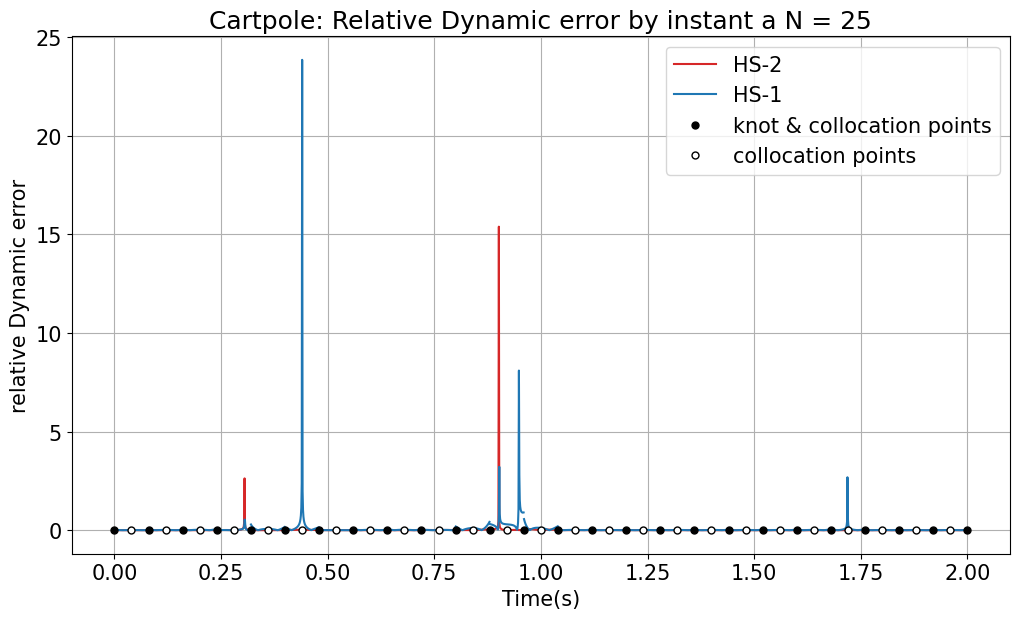

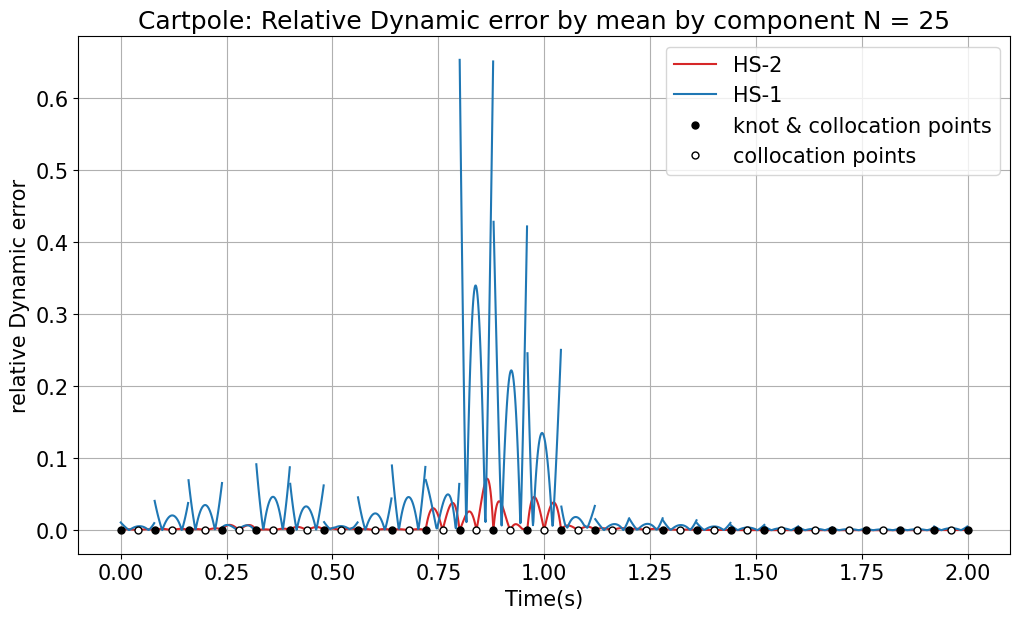

In [51]:
schemes = ['hs_mod_parab','hs_parab']
N = 25
for ii in range(len(error_types)):
    error_type = error_types[ii]
    err_title = error_titles[ii]
    plot_by_segments(results, schemes, N,
                 thing_to_plot = error_type,
                 title = r'Cartpole: Relative Dynamic error ' + err_title +f' N = {N}',
                 ylabel = 'relative Dynamic error')

In [52]:
for scheme in results.keys():
    _n = 25 if 'hs' in scheme else 50
    _e = results[scheme][_n]['rel_dyn_err_2_arr_by_mean_by_component_sum']
    print(f'scheme {scheme.ljust(12)} N {_n} avg {round(np.mean(_e), 4)} max {round(np.max(_e), 3)}')

scheme hs_parab     N 25 avg 0.0317 max 0.652
scheme hs_mod_parab N 25 avg 0.0047 max 0.071
scheme trapz        N 50 avg 0.1314 max 1.611
scheme trapz_mod    N 50 avg 0.0153 max 0.209


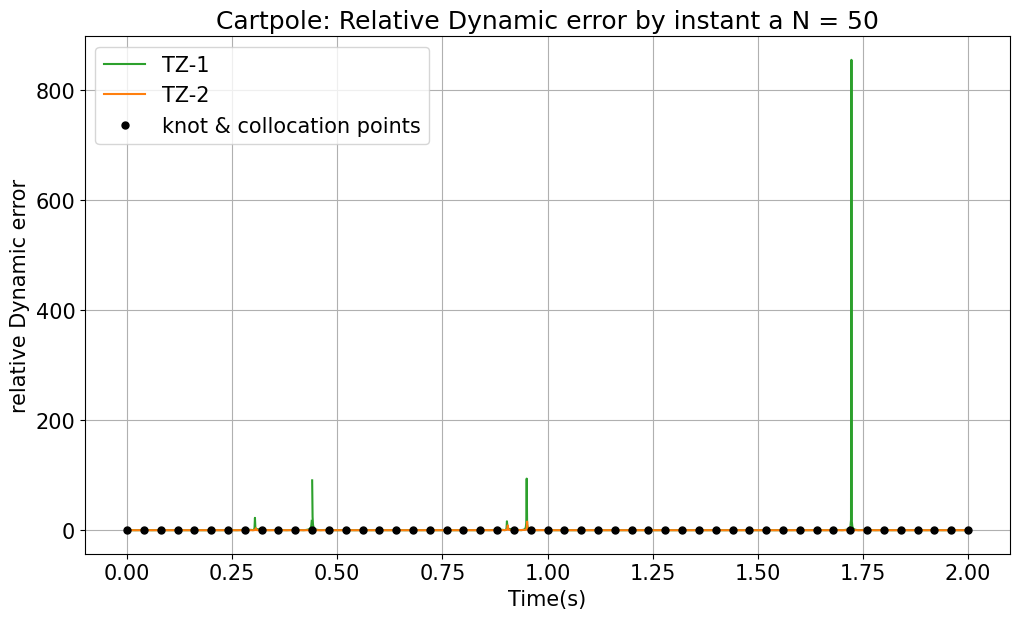

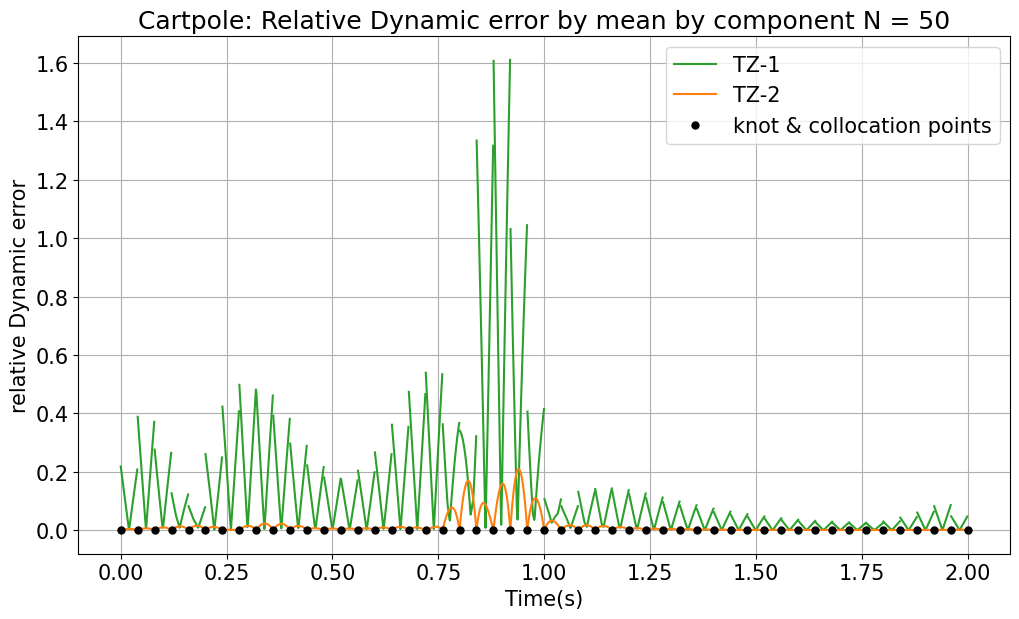

In [53]:
schemes = ['trapz', 'trapz_mod']
N = 50
for ii in range(len(error_types)):
    error_type = error_types[ii]
    err_title = error_titles[ii]
    plot_by_segments(results, schemes, N,
                 thing_to_plot = error_type,
                 title = r'Cartpole: Relative Dynamic error ' + err_title +f' N = {N}',
                 ylabel = 'relative Dynamic error')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


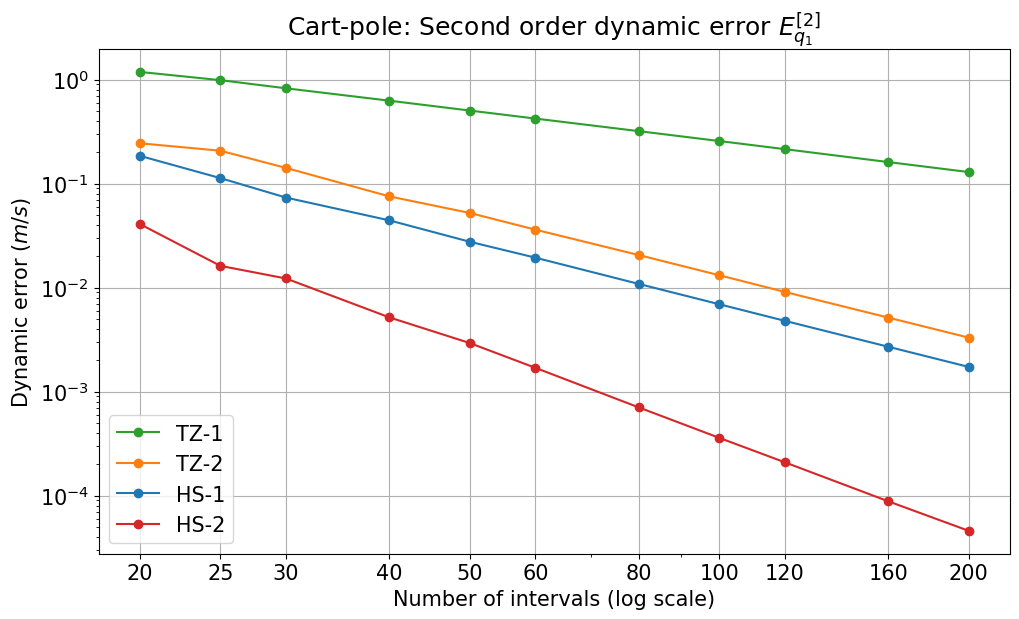

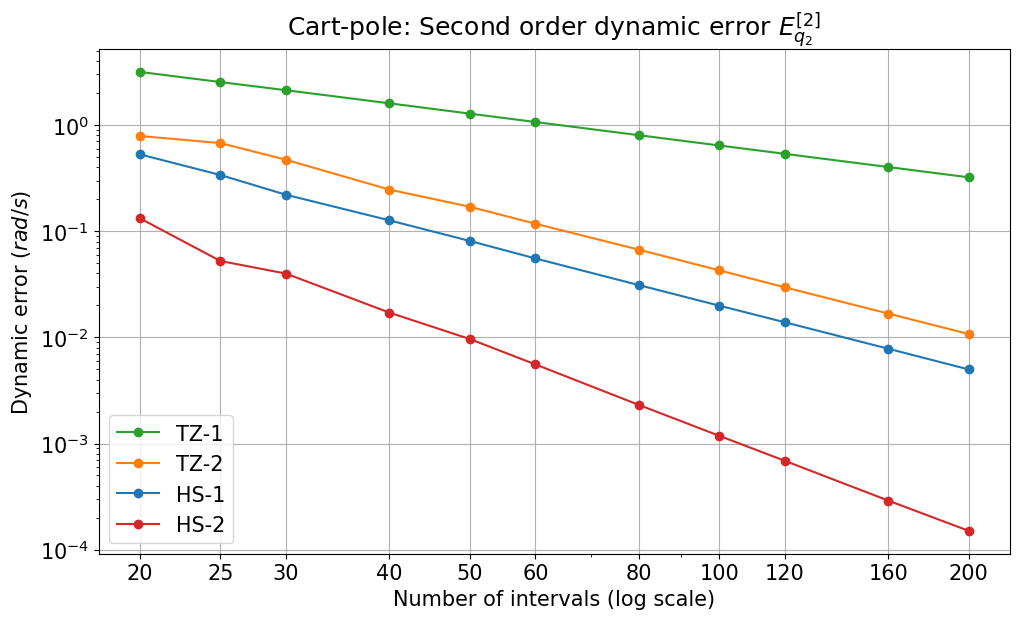

In [54]:

data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
schemes = ['trapz', 'trapz_mod','hs_parab', 'hs_mod_parab',]




data_key = data_array[2]
for qq in range(2):
    plt.figure(figsize=oct_fig_size)
    plt.title(f'Cart-pole: Second order dynamic error $E^{{[2]}}_{{q_{qq+1}}}$')
    for key in schemes:
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **scheme_kwargs(key, longlabel=False))
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **scheme_kwargs(key, longlabel=False))
    plt.yscale('log')
    plt.xscale('log')
    ticks = np.array(results[key]['N_arr'])
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of intervals (log scale)')
    plt.grid()
    plt.legend()
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamic error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    plt.savefig(f'2d_order/Cartpole_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


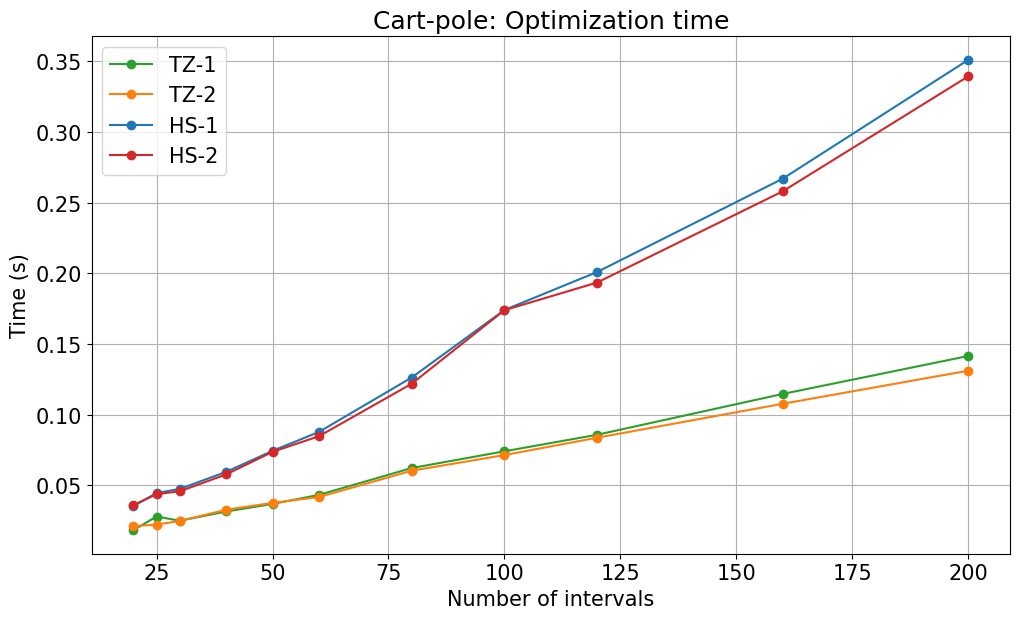

In [55]:
schemes = ['hs_mod_parab','hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=[10,6])
for ii in [2,3,1,0]:
    key = schemes[ii]
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
plt.title('Cart-pole: Optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
plt.savefig(f'2d_order/Cartpole_optimization_time_vs_interval_number.eps', format='eps')

In [56]:
# Here we print the data shown in Table II of the paper
for scheme in ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2'])

scheme: hs_mod_parab N: 25 
	time: 0.04383010864257812 
	Err 1: [4.55592709e-21 1.73559127e-20] 
	Err 2: [0.01619399 0.05244979]
scheme: hs_parab N: 25 
	time: 0.04465172290802002 
	Err 1: [0.00142528 0.00426119] 
	Err 2: [0.11292811 0.33857118]
scheme: trapz N: 50 
	time: 0.036931204795837405 
	Err 1: [0.00661654 0.01670678] 
	Err 2: [0.50381319 1.28127828]
scheme: trapz_mod N: 50 
	time: 0.03767130374908447 
	Err 1: [1.21491389e-20 4.59931687e-20] 
	Err 2: [0.05221933 0.17005427]


## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)